# Monocular Depth Estimation Using U-Net and MobileNetV3 on Jetson TX2 NX Devices

This model aims for monocular depth estimation using a U-Net architecture with a MobileNetV3 as the encoder. The model is trained on the DIODE Indoor Dataset.

The model are built using the pytorch and then will be converted to ONNX then to a TensorRT engine for inference on the Jetson TX2 NX device.

The model is trained using the Adam optimizer with a learning rate of 0.0001 (Can be changed). The model is trained using the mean squared error loss function.

For more information on the model, please refer to the following paper: https://arxiv.org/pdf/2004.04572.pdf

An Aditional information can be accessed in the following link: https://github.com/alinstein/Depth_estimation, https://www.kaggle.com/code/muhammadhafil/monocular-depth-estimation and https://www.kaggle.com/code/harits/indoor-depth-estimation-u-net

The dataset used for training can be found in the following link: https://diode-dataset.org/ or https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image

# Class
from NYUDataset import Dataset
from Model import Model

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 28, 28, 40), (None, 14, 14, 40)]

# Hyperparameters

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.0001
HEIGHT = 192
WIDTH = 256

# Dataset Preparation

In [ ]:
# Dataset preparation
train_csv = "./data/nyu2_train.csv"
train_ims_path = "./data/nyu2_train_images/"
base_path = "./"

df = pd.read_csv(train_csv, header=None)
df[0] = df[0].map(lambda x: os.path.join(base_path, x))
df[1] = df[1].map(lambda x: os.path.join(base_path, x))

df.head()

,0,1
0,./data/nyu2_train/living_room_0038_out/37.jpg,./data/nyu2_train/living_room_0038_out/37.png
1,./data/nyu2_train/living_room_0038_out/115.jpg,./data/nyu2_train/living_room_0038_out/115.png
2,./data/nyu2_train/living_room_0038_out/6.jpg,./data/nyu2_train/living_room_0038_out/6.png
3,./data/nyu2_train/living_room_0038_out/49.jpg,./data/nyu2_train/living_room_0038_out/49.png
4,./data/nyu2_train/living_room_0038_out/152.jpg,./data/nyu2_train/living_room_0038_out/152.png


In [ ]:
# Train-test split
train_df, val_df = train_test_split(df, test_size=0.1, shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1, shuffle=True)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
len(train_df),len(val_df), len(test_df)

(45619, 4562, 507)

# Visualize the Depth Map

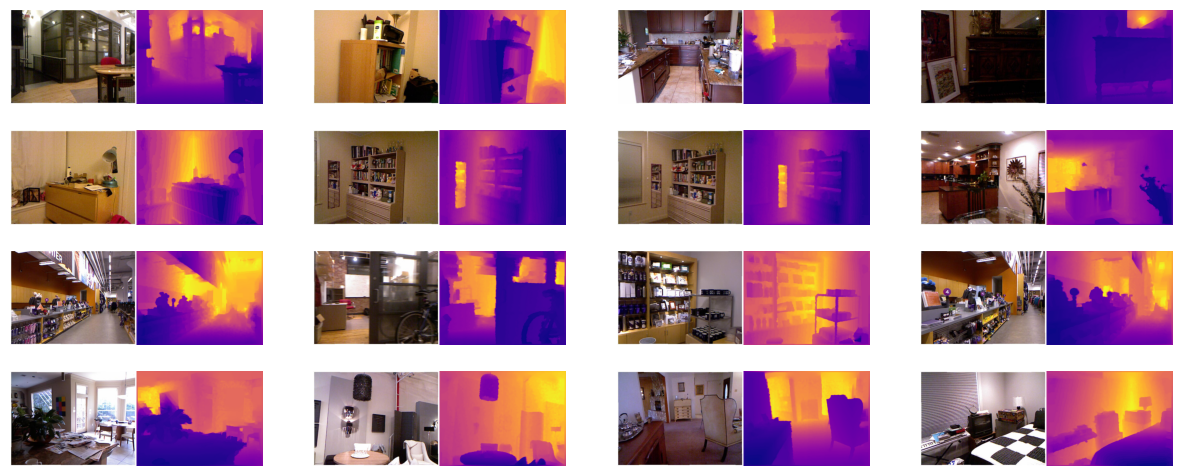

In [ ]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.plasma):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Dataset

In [ ]:
def tf_train_augment(image, label):
    # Horizontal Flip
    image = tf.image.random_flip_left_right(image)

    # Gaussian Noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0., stddev=1.)
    image = tf.cond(tf.random.uniform(()) < 0.2, lambda: image + noise, lambda: image)

    # Random blurs: MotionBlur, MedianBlur, Blur
    # Note: TensorFlow does not natively support motion blur or median blur. 
    # You might need custom implementations for these. Here, I'm using Gaussian blur as an example.
    image = tf.cond(
        tf.random.uniform(()) < 0.3,
        lambda: tf.image.random_gaussian_blur(image, filter_shape=(3, 3), sigma=0.5),
        lambda: image
    )

    # RGBShift is not natively supported in TensorFlow. You might need a custom function.

    # Random Brightness & Contrast
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.2, 0.5)

    # Random Resized Crop
    image = tf.image.random_crop(image, size=[384, 384, 3])

    # Color Jitter: Using Random Hue and Saturation as approximations
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 0.6, 1.6)

    # Shift, Scale and Rotate
    # Note: For simplicity, only the rotation is shown here. Shift and Scale would need custom implementations.
    image = tf.cond(
        tf.random.uniform(()) < 0.5,
        lambda: tf.image.rot90(image, k=tf.random.uniform(shape=(), minval=1, maxval=4, dtype=tf.int32)),
        lambda: image
    )

    # Resize and Normalize
    image = tf.image.resize(image, [224, 224])
    image = tf.image.per_image_standardization(image)  # Normalizing using per-image statistics

    return image, label

def tf_valid_augment(image, label):
    # Resize and Normalize
    image = tf.image.resize(image, [224, 224])
    image = tf.image.per_image_standardization(image)  # Normalizing using per-image statistics

    return image, label

In [ ]:
# Create TensorFlow datasets
tf_train_ds = Dataset(train_df, tf_train_augment).create_tf_dataset()
tf_val_ds = Dataset(val_df, tf_valid_augment).create_tf_dataset()
tf_test_ds = Dataset(test_df, tf_valid_augment).create_tf_dataset()

# Get the lengths (number of samples) of the datasets
len_tf_train_ds = tf.data.experimental.cardinality(tf_train_ds).numpy()
len_tf_val_ds = tf.data.experimental.cardinality(tf_val_ds).numpy()
len_tf_test_ds = tf.data.experimental.cardinality(tf_test_ds).numpy()

len_tf_train_ds, len_tf_val_ds, len_tf_test_ds

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(45619, 4562, 507)

In [ ]:
# Batch and shuffle the TensorFlow datasets
tf_train_dl = tf_train_ds.shuffle(buffer_size=len_tf_train_ds).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
tf_val_dl = tf_val_ds.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
tf_test_dl = tf_test_ds.shuffle(buffer_size=len_tf_test_ds).batch(4).prefetch(tf.data.experimental.AUTOTUNE)

# Get the number of batches for each dataset
len_tf_train_dl = tf.data.experimental.cardinality(tf_train_dl).numpy()
len_tf_val_dl = tf.data.experimental.cardinality(tf_val_dl).numpy()
len_tf_test_dl = tf.data.experimental.cardinality(tf_test_dl).numpy()

len_tf_train_dl, len_tf_val_dl, len_tf_test_dl

(713, 72, 127)

# Loss Function and Metrics
The loss function used are SSIM and MSE. The SSIM is used to measure the similarity between two images, while the MSE is used to measure the difference between two images. 

The metrics used are RMSE, MAE, and SSIM. The RMSE is used to measure the difference between the predicted depth map and the ground truth depth map. The MAE is used to measure the difference between the predicted depth map and the ground truth depth map. The SSIM is used to measure the similarity between the predicted depth map and the ground truth depth map.

In [ ]:
def unnormalize(tensor, mean, std):
    channels = len(mean)
    new_tensor = tensor * std + mean
    return new_tensor

def plot_vals(imgs, preds, targets, n=4, figsize=(6,2), title=''):
    plt.figure(figsize=figsize, dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i, idx in enumerate(np.random.randint(0, imgs.shape[0], (n,))):
        ax = plt.subplot(r, c, i + 1)
        
        # Using tf.gather for indexing along the first axis
        img, pred, gt = tf.gather(imgs, idx), tf.gather(preds, idx), tf.gather(targets, idx)
        
        mean = tf.constant([0.485, 0.456, 0.406])
        std = tf.constant([0.229, 0.224, 0.225])
        
        img = unnormalize(img, mean, std) * 255.0
        
        # Convert to numpy for visualization
        img, pred, gt = img.numpy(), pred.numpy(), gt.numpy()
        
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        
        image_viz = np.hstack([img, pred, gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    
    title = f'{title}\nimage/target/prediction' if len(title) != 0 else 'image/target/prediction'
    plt.suptitle(title)
    plt.show()

In [13]:
import tensorflow as tf

# 1. Define the metrics

# RMSE
class RMSE(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RMSE, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError()
        self.value = self.add_weight(name="rmse", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        mse = self.mse(y_true, y_pred)
        value = tf.sqrt(mse)
        self.value.assign(value)

    def result(self):
        return self.value

# REL
class REL(tf.keras.metrics.Metric):
    def __init__(self, name='rel', **kwargs):
        super(REL, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        rel_error = tf.reduce_sum(tf.abs(y_pred - y_true) / y_true)
        self.total.assign_add(rel_error)
        self.count.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))

    def result(self):
        return self.total / self.count

# SSIM (for simplicity, using a fixed max value of 1.0)
def compute_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)


# 2. Set up the model, loss function, optimizer, and learning rate scheduler

# Load the model (using the previously defined create_unet_mobilenetv3 function)
model_tf = Model()

# Loss function
loss_fn_tf = tf.keras.losses.MeanSquaredError()

# Optimizer
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=1e-5)

# Learning rate scheduler
steps_per_epoch = len_tf_train_dl  # Assuming you've already calculated the length of the training data loader
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE, decay_steps=steps_per_epoch*EPOCHS, decay_rate=0.9)
optimizer_tf.learning_rate = lr_schedule

# Metrics collection
train_metrics = [RMSE(), REL(), tf.keras.metrics.MeanAbsoluteError(), compute_ssim]
val_metrics = [RMSE(), REL(), tf.keras.metrics.MeanAbsoluteError(), compute_ssim]

# Training

In [14]:
BEST_SSIM = -1e9
BEST_EPOCH = -1

In [ ]:
print("Training Started...")

for epoch in tqdm(range(EPOCHS)):
    model.train()

    if epoch == FREEZE_EPOCHS:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')
        
    running_loss = 0.
    train_progress = tqdm(train_dl, total=len(train_dl))

    for img, mask in train_progress:
        with torch.cpu.amp.autocast(): # chage to cuda if you have GPU
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)
            pred = model(img)
            loss = loss_fn(pred, mask)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            train_progress.set_description(f"Epoch: {epoch+1}/{EPOCHS}, LR: {optimizer.param_groups[0]['lr']:.1e}, Loss: {running_loss:.4f}")

            train_metrics(pred, mask)

        del img, mask, pred, loss

    m = train_metrics.compute()
    _ssim, _mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
    logs.loc[epoch, ['loss_train','ssim_train','mse_train']] = (running_loss/len(train_dl), _ssim, _mse)
    train_metrics.reset()
    model.eval()

    with torch.no_grad():
        running_loss = 0.

        val_progress = tqdm(val_dl, total=len(val_dl))

        for img, mask in val_progress:
            with torch.cpu.amp.autocast(): # chage to cuda if you have GPU
                img = img.to(DEVICE)
                mask = mask.to(DEVICE)
                pred = model(img)
                loss = loss_fn(pred, mask)
                running_loss += loss.item()
                val_progress.set_description(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}")

                val_metrics(pred, mask)

            del img, mask, pred, loss

        m = val_metrics.compute()
        _ssim, _mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
        logs.loc[epoch, ['loss_val','ssim_val','mse_val']] = (running_loss/len(val_dl), _ssim, _mse)
        val_metrics.reset()

        if _ssim > BEST_SSIM:
            BEST_SSIM = _ssim
            BEST_EPOCH = epoch
            sd = model.state_dict()
            torch.save(sd, 'UnetMobilenetV3.pt')

        print(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, SSIM: {_ssim:.4f}, MSE: {_mse:.4f}, BEST SSIM: {BEST_SSIM:.4f} at Epoch: {BEST_EPOCH+1}")

        with torch.no_grad():
            imgs, masks = next(iter(test_dl))
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            preds = model(imgs)
            plot_vals(imgs.cpu(), preds.cpu(), masks.cpu(), title=f"Epoch: {epoch+1}")

        gc.collect()
        # torch.cuda.empty_cache()